# Non-stationary SNR with propagation delay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from functions.epsilon_greedy_agent import get_action_epsilon_greedy
from functions.rewards import get_reward
from tqdm import tqdm
from functions.ucb_agent import train_ucb_agent_non_stat
from functions.epsilon_greedy_agent import train_agent_epsilon_greedy_non_stat

In [42]:
# Fix the seed
np.random.seed(1)
# Number of agents
C_N_AGENTS = 2000
# Maximal time in s
C_T_MAX = 1000
# Learning-rate
C_LEARNING_RATE = 0.1
# Signal to Noise Ratio in dB
C_SNR_DB = 5
# Sampling frequency in Hz
C_SAMPLING_FREQ_HZ = 1
# Coherence time in s
C_COHERENCE_S = 60
# Power spread in dB
C_POWER_SPREAD = 10
# Bitrates in bits/s
C_BITRATES_BITS_PER_S =np.array([2520, 840, 360, 168])
# Warming time
C_WARMING_TIME_S = 50

In [43]:
def ar1_channel_power(P_avg_dB, sigma2_P_dB, tc, fs, D):
    n_tc = tc*fs
    phi = np.exp(-np.log(2)/n_tc)
    var_e = sigma2_P_dB*(1 - phi**2)
    
    C_NWARM = int(C_WARMING_TIME_S * fs)
    N = np.ceil(D*fs).astype(int)

    Y = np.zeros(C_NWARM + N)
    e = np.sqrt(var_e)*np.random.randn(C_NWARM + N)

    for k in range(1, C_NWARM + N):
        Y[k] = phi*Y[k-1] + e[k]

    P_dB = P_avg_dB + Y[C_NWARM:]

    return P_dB

In [44]:
# Get the SNR trajectory
v_snr = ar1_channel_power(C_SNR_DB, C_POWER_SPREAD, C_COHERENCE_S, C_SAMPLING_FREQ_HZ, C_T_MAX)

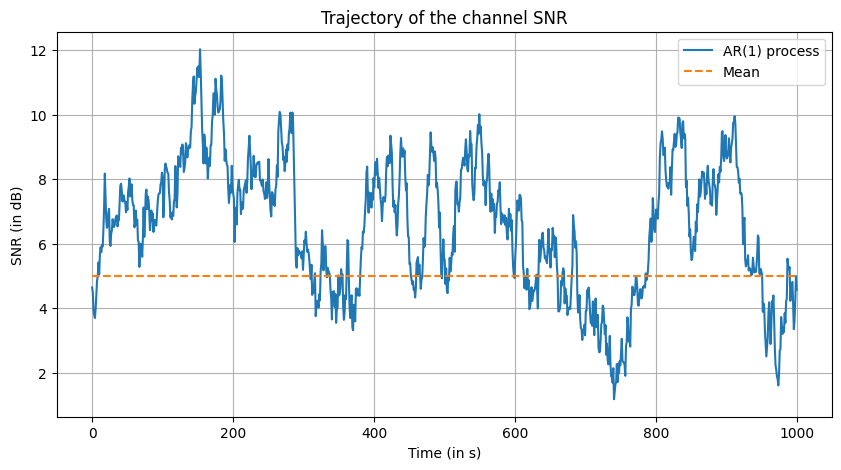

In [45]:
# Plot of the SNR trajectory
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(v_snr, label = "AR(1) process")
ax.plot(np.ones_like(v_snr) * C_SNR_DB, label = "Mean", linestyle = "dashed")
ax.set_xlabel('Time (in s)')
ax.set_ylabel('SNR (in dB)')
ax.set_title('Trajectory of the channel SNR')
ax.grid(True)
ax.legend()
plt.show()

In [46]:
def supposed(x , alpha, offset, factor, up):
    return factor*(((np.exp(-alpha*(x-offset)) - np.exp(alpha*(x-offset)))/(np.exp(-alpha*(x-offset)) + np.exp(alpha*(x-offset)))) + up)

def anal_estimation(supposed_general_form, x_data, y_data):
    popt, _ = curve_fit(supposed_general_form, x_data, y_data,bounds=([0,-20,0,0],[2,20,1,5]), maxfev=5000)
    alpha, offset, factor, up = popt
    
    def estimation(X):
        return supposed(X, alpha, offset, factor, up)
    
    return estimation

In [47]:
# Read the .csv file containing the PER
df = pd.read_csv('data/TEP_vs_SNR.csv')
labels = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"]

df_per = pd.DataFrame()
df_per['SNR'] = df.T.index[1:].astype(np.float32)
df_per['TEP_DSSS1'] = df.T[0].to_list()[1:]
df_per['TEP_DSSS3'] = df.T[1].to_list()[1:]
df_per['TEP_DSSS7'] = df.T[2].to_list()[1:]
df_per['TEP_DSSS15'] = df.T[3].to_list()[1:]


# Interpolation
f_DSSS1 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS1']))
f_DSSS3 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS3']))
f_DSSS7 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS7']))
f_DSSS15 = anal_estimation(supposed, df_per['SNR'], np.array(df_per['TEP_DSSS15']))

# Compute the PER values for each modulation at each time
# using the interpolations
per_values = np.vstack((f_DSSS1(v_snr), f_DSSS3(v_snr), f_DSSS7(v_snr), f_DSSS15(v_snr))).T

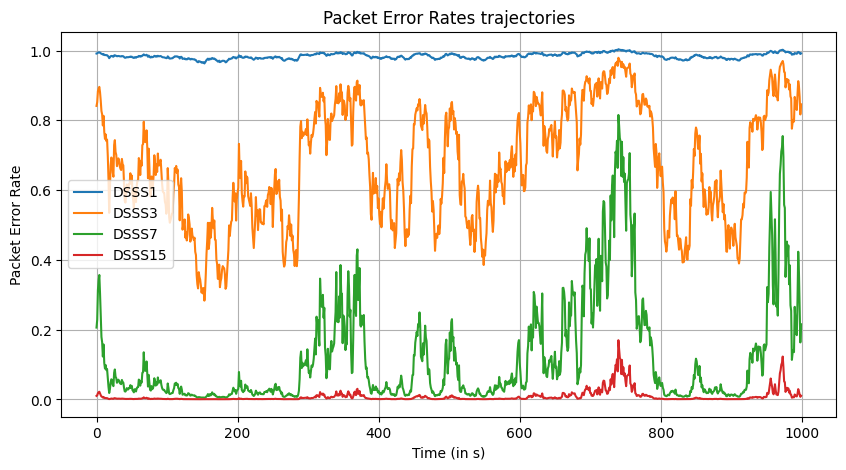

In [48]:
# Plot of the inteprolated PER curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(per_values, label = ["DSSS1", "DSSS3", "DSSS7", "DSSS15"])
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Packet Error Rate')
ax.set_title('Packet Error Rates trajectories')
ax.grid(True)
ax.legend()
plt.show()

In [70]:
def train(n_iter, n_agents, alpha, eps, bitrates, delay):
    k = bitrates.size
    action_values = np.zeros((n_iter, n_agents, k))
    rewards = np.zeros((n_iter, n_agents))
    actions_chosen = np.zeros((n_iter, n_agents, k))

    for t in range(n_iter):
        snr = v_snr[t] # Current SNR
        per_values = np.array([f_DSSS1(snr), f_DSSS3(snr), f_DSSS7(snr), f_DSSS15(snr)])
   
        for agent in range(n_agents):
            action = get_action_epsilon_greedy(action_values[t, agent, :], eps)

            reward = get_reward(per_values, bitrates, action)
            rewards[t, agent] = reward

            if t >= delay:
                # Update the value of the action taken at time step t-delay
                # This action is contained in the variable past_action
                past_action = np.where(actions_chosen[t - delay, agent, :]==1)[0][0]
                action_values[t + 1:, agent, past_action] = action_values[t, agent, past_action] + alpha*(rewards[t - delay, agent] - action_values[t, agent, past_action])
            else:
                action_values[t + 1:, agent, action] = action_values[t, agent, action]
            actions_chosen[t, agent, action] = 1
    return action_values, rewards, actions_chosen

In [71]:
delay = 1
eps = 0.05
n_iter = v_snr.size
alpha = [1e-3, 1e-2, 0.1]
_, rewards1, _ = train(n_iter, C_N_AGENTS, alpha[0], eps, C_BITRATES_BITS_PER_S, delay)
_, rewards2, _ = train(n_iter, C_N_AGENTS, alpha[1], eps, C_BITRATES_BITS_PER_S, delay)
_, rewards3, _ = train(n_iter, C_N_AGENTS, alpha[2], eps, C_BITRATES_BITS_PER_S, delay)

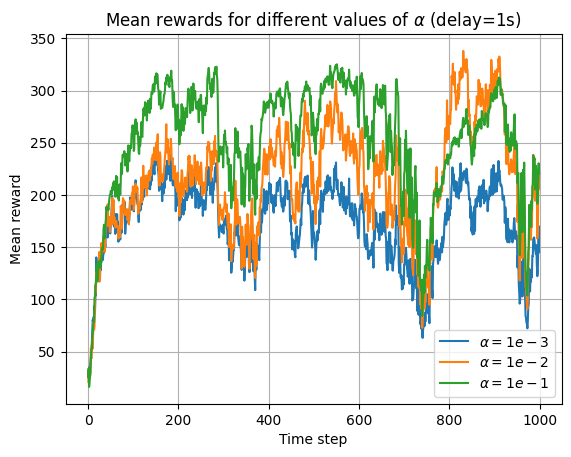

In [72]:
plt.plot(np.mean(rewards1, axis=1), label=r'$\alpha=1e-3$')
plt.plot(np.mean(rewards2, axis=1), label=r'$\alpha=1e-2$')
plt.plot(np.mean(rewards3, axis=1), label=r'$\alpha=1e-1$')
plt.title(r'Mean rewards for different values of $\alpha$'+f' (delay={delay}s)')
plt.xlabel('Time step')
plt.ylabel('Mean reward')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
delay = 5
eps = 0.05
n_iter = v_snr.size
alpha = [1e-3, 1e-2, 0.1]
_, rewards1, _ = train(n_iter, C_N_AGENTS, alpha[0], eps, C_BITRATES_BITS_PER_S, delay=delay)
_, rewards2, _ = train(n_iter, C_N_AGENTS, alpha[1], eps, C_BITRATES_BITS_PER_S, delay=delay)
_, rewards3, _ = train(n_iter, C_N_AGENTS, alpha[2], eps, C_BITRATES_BITS_PER_S, delay=delay)

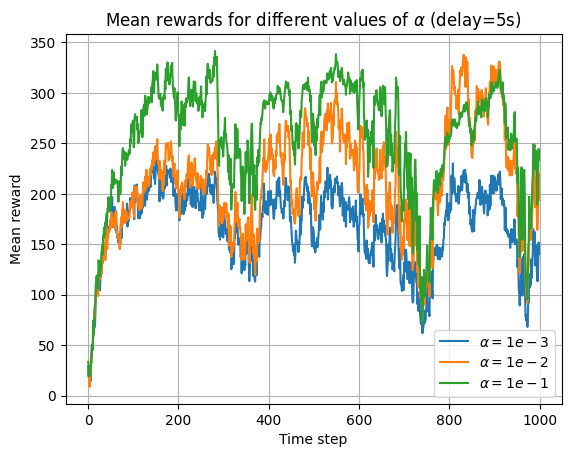

In [74]:
plt.plot(np.mean(rewards1, axis=1), label=r'$\alpha=1e-3$')
plt.plot(np.mean(rewards2, axis=1), label=r'$\alpha=1e-2$')
plt.plot(np.mean(rewards3, axis=1), label=r'$\alpha=1e-1$')
plt.title(r'Mean rewards for different values of $\alpha$'+f' (delay={delay}s)')
plt.xlabel('Time step')
plt.ylabel('Mean reward')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
delay = 10
eps = 0.05
n_iter = v_snr.size
alpha = [1e-3, 1e-2, 0.1]
_, rewards1, _ = train(n_iter, C_N_AGENTS, alpha[0], eps, C_BITRATES_BITS_PER_S, delay=delay)
_, rewards2, _ = train(n_iter, C_N_AGENTS, alpha[1], eps, C_BITRATES_BITS_PER_S, delay=delay)
_, rewards3, _ = train(n_iter, C_N_AGENTS, alpha[2], eps, C_BITRATES_BITS_PER_S, delay=delay)

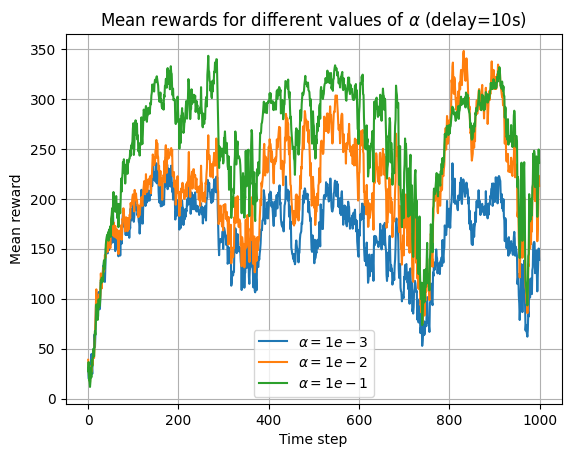

In [76]:
plt.plot(np.mean(rewards1, axis=1), label=r'$\alpha=1e-3$')
plt.plot(np.mean(rewards2, axis=1), label=r'$\alpha=1e-2$')
plt.plot(np.mean(rewards3, axis=1), label=r'$\alpha=1e-1$')
plt.title(r'Mean rewards for different values of $\alpha$'+f' (delay={delay}s)')
plt.xlabel('Time step')
plt.ylabel('Mean reward')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
eps_values = np.linspace(0, 1, num=10)
alpha = 1e-1
delay = 1
total_rewards = list()

for eps in tqdm(eps_values):
    _, rewards, _ = train(n_iter, C_N_AGENTS, alpha, eps, C_BITRATES_BITS_PER_S, delay=delay)
    total_rewards.append(np.mean(rewards[-1, :]))

100%|██████████| 10/10 [05:38<00:00, 33.81s/it]


In [29]:
# Get the optimal epsilon values
eps_opt = eps_values[np.argmax(total_rewards)]

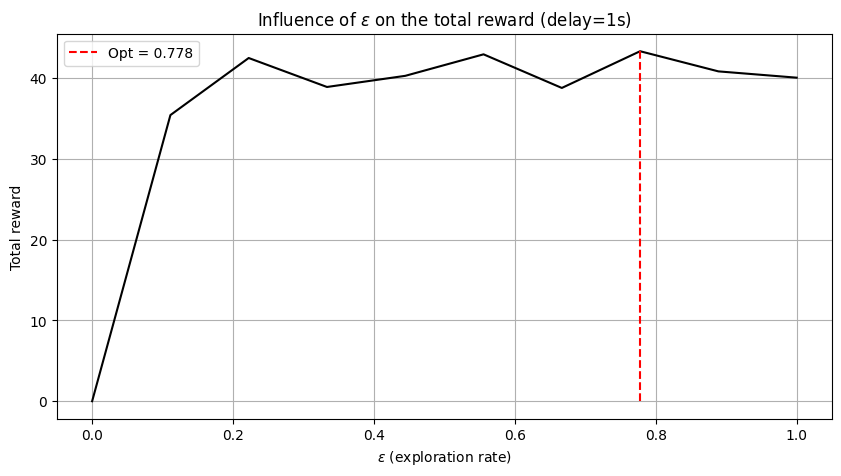

In [31]:
# Plot the 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(eps_values, total_rewards, color='k')
ax.plot([eps_opt, eps_opt], [0, np.max(total_rewards)], color = 'r', label = f"Opt = {eps_opt:.3f}", linestyle = "dashed")
ax.grid(True)
ax.legend()
ax.set_xlabel(r'$\varepsilon$ (exploration rate)')
ax.set_ylabel('Total reward')
ax.set_title(r'Influence of $\varepsilon$ on the total reward'+f' (delay={delay}s)')
plt.show()

In [77]:
alpha = 0.1
delay = 1
eps = 0.1
_, _, actions_chosen = train(n_iter, C_N_AGENTS, alpha, eps, C_BITRATES_BITS_PER_S, delay=delay)

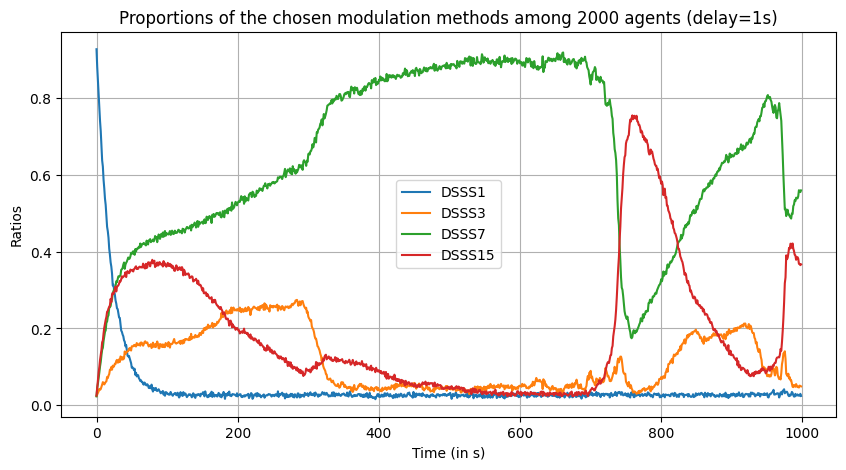

In [78]:
# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_chosen[1:, :, :], axis = 1), label=['DSSS1', 'DSSS3', 'DSSS7', 'DSSS15'])
ax.grid(True)
ax.legend()
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {C_N_AGENTS} agents'+f' (delay={delay}s)')
plt.show()

In [79]:
alpha = 0.1
delay = 5
eps = 0.1
_, _, actions_chosen = train(n_iter, C_N_AGENTS, alpha, eps, C_BITRATES_BITS_PER_S, delay=delay)

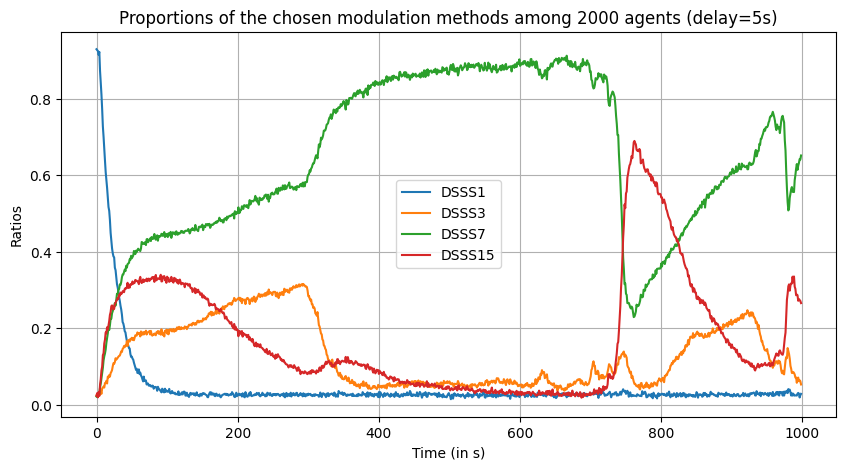

In [80]:
# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_chosen[1:, :, :], axis = 1), label=['DSSS1', 'DSSS3', 'DSSS7', 'DSSS15'])
ax.grid(True)
ax.legend()
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {C_N_AGENTS} agents'+f' (delay={delay}s)')
plt.show()

In [83]:
alpha = 0.1
delay = 10
eps = 0.1
_, _, actions_chosen = train(n_iter, C_N_AGENTS, alpha, eps, C_BITRATES_BITS_PER_S, delay=delay)

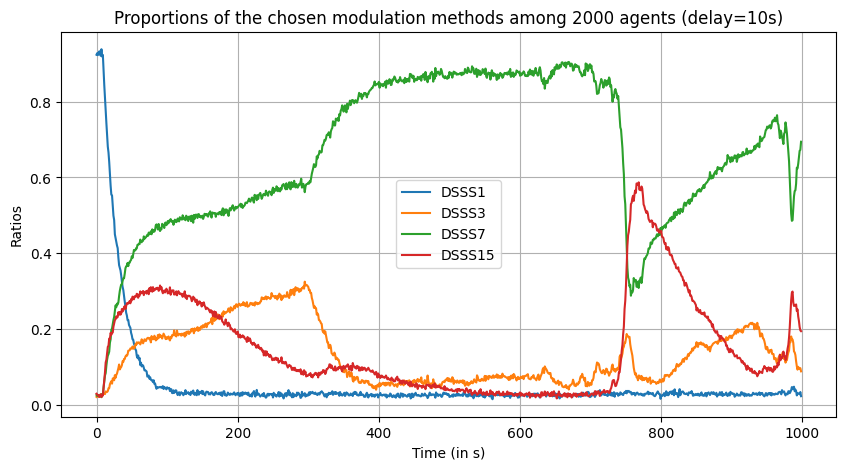

In [84]:
# Plot of the ratios
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.mean(actions_chosen[1:, :, :], axis = 1), label=['DSSS1', 'DSSS3', 'DSSS7', 'DSSS15'])
ax.grid(True)
ax.legend()
ax.set_xlabel('Time (in s)')
ax.set_ylabel('Ratios')
ax.set_title(f'Proportions of the chosen modulation methods among {C_N_AGENTS} agents'+f' (delay={delay}s)')
plt.show()